In [68]:
import pandas as pd
dating = pd.read_csv("profiles.csv")

In [69]:
# basic data cleanup
# income
dating.loc[dating["income"] == -1, "income"] = pd.NA

# Let's create ML algorithm that will predict drug use

prepare data some more for drug investigation

In [70]:
# create some suspicios words list that may relate to drug use to filter from essays
drug_words = ["party", "fun", "hang out", "festival", "good time", "drink"]
essay_cols = [col for col in dating.columns if col.startswith("essay")]
for word in drug_words:
    dating[word + "_count"] = dating[essay_cols].apply(
        lambda row: sum(str(cell).lower().count(word) for cell in row if pd.notna(cell)),
        axis=1
    )
    
dating = dating.drop(columns=essay_cols)

Prepare data for machine learning

In [71]:
drugs_values = dating["drugs"].value_counts()
dating_drugs_filled = dating.dropna(subset=["drugs"])
dating_drugs_missing = dating[dating["drugs"].isna()]
features = dating_drugs_filled.drop(columns=["drugs"])
labels = dating_drugs_filled["drugs"]
features["education"][features["education"].str.contains("graduated", na=False)].value_counts()
features["religion"].value_counts()
labels.value_counts(normalize=True)

drugs
never        0.822483
sometimes    0.168578
often        0.008939
Name: proportion, dtype: float64

In [72]:
# prepare features for ML
features = pd.get_dummies(features, columns=["body_type", "drinks", "job", "orientation", "pets"], dummy_na=False)

from tools import bucket_education, is_strict_diet

# extract most common single ethnicities (about 5), rest as "other"
# literal list based on value_counts and inspection
ethnicities = [
    "white",
    "asian",
    "black",
    "hispanic / latin",
    "other",
    "middle eastern",
    "native american",
    "pacific islander",
    "indian"
]
for ethn in ethnicities:
    features[ethn] = features["ethnicity"].apply(lambda val: True if pd.notna(val) and ethn in val else False)

features["education_bucket"] = features["education"].apply(bucket_education)
features = pd.get_dummies(features, columns=["education_bucket"], dummy_na=False)
features["male"] = features["sex"].apply(lambda val: True if val == "m" else False)
features["smokes"] = features["smokes"].apply(lambda val: False if val == "no" else True)
features["is_single"] = features["status"].apply(lambda val: True if val == "single" else False)
features["has_kid_s"] = features["offspring"].apply(lambda val: True if pd.notna(val) and "has" in val else False)
features["strict_diet"] = features["diet"].apply(is_strict_diet)
features["strict_religion"] = features["religion"].apply(lambda val: True if pd.notna(val) and "very serious about it" in val else False)
diets = ["vegan", "vegetarian", "halal", "kosher"]
for diet in diets:
    features[diet] = features["diet"].apply(lambda val: True if pd.notna(val) and diet in val else False)

features = features.select_dtypes(include=["number", "bool"])

In [73]:
# just to verify the bucketing is working as intended
education_unique = dating["education"].dropna().unique()
education_buckets = {edu: bucket_education(edu) for edu in education_unique}
education_buckets

{'working on college/university': 'high_school',
 'working on space camp': 'lower',
 'graduated from masters program': 'graduated',
 'graduated from college/university': 'graduated',
 'working on two-year college': 'high_school',
 'graduated from high school': 'high_school',
 'working on masters program': 'high_school',
 'graduated from space camp': 'high_school',
 'college/university': 'graduated',
 'dropped out of space camp': 'lower',
 'graduated from ph.d program': 'Ph.D',
 'graduated from law school': 'high_school',
 'working on ph.d program': 'graduated',
 'two-year college': 'graduated',
 'graduated from two-year college': 'graduated',
 'working on med school': 'lower',
 'dropped out of college/university': 'high_school',
 'space camp': 'high_school',
 'graduated from med school': 'high_school',
 'dropped out of high school': 'lower',
 'working on high school': 'lower',
 'masters program': 'graduated',
 'dropped out of ph.d program': 'graduated',
 'dropped out of two-year colleg

let's go with decision tree model first

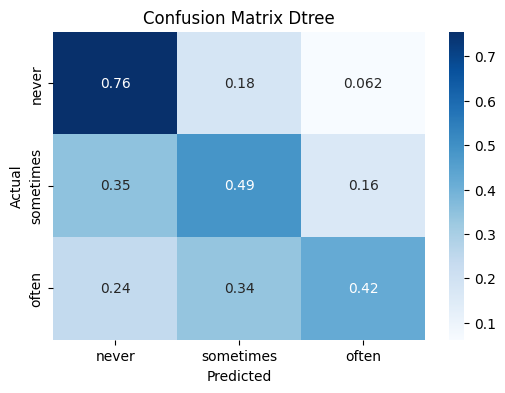

0.43899808836038484

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.2, random_state=21)
dtree = DecisionTreeClassifier(class_weight="balanced", max_depth=10, random_state=10)
dtree.fit(x_train, y_train)

cm = confusion_matrix(y_test, dtree.predict(x_test), normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Dtree')
plt.show()
f1_score(y_test, dtree.predict(x_test), average="macro")

We see not so great performance by the decision tree model.

Let's try something, that takes in account the ordinality of labels.

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# scale and normalise data for use with regression models
ord_map = {'never': 0, 'sometimes': 1, 'often': 2}
labels = labels.map(ord_map)
scaler = StandardScaler()
imputer = SimpleImputer(strategy="median")
# Apply scaler only to int and float columns
num_cols = features.select_dtypes(include=["int", "float"]).columns
features[num_cols] = scaler.fit_transform(features[num_cols])
features[num_cols] = imputer.fit_transform(features[num_cols])


In [77]:
from sklearn.linear_model import LogisticRegression
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.2, random_state=21)
log_regressor = LogisticRegression(random_state=10, max_iter=1000)
log_regressor.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=10)

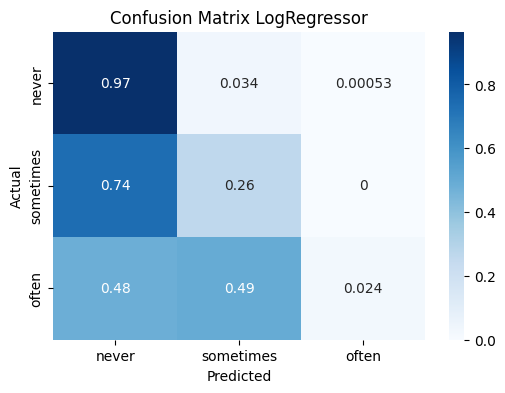

0.43880106121685936

In [83]:
# evaluate performance
y_pred = log_regressor.predict(x_test)

cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix LogRegressor')
plt.show()
f1_score(y_test, y_pred, average="macro")

still far from working model, let's try custom thresholding to improve the predictions

Best 'often' thresh: 0.09896755439047003 F1_often: 0.24581005586542443
Best 'sometimes' thresh: 0.2382997131172823 F1_sometimes: 0.5107451855981718


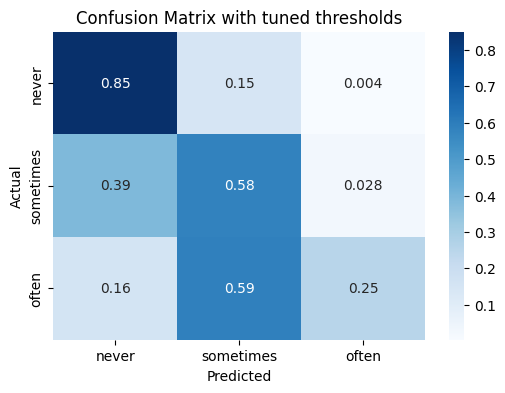

0.5399682757763268

In [93]:
from tools import get_best_thresholds, predict_with_thresholds

# 1) Get predicted probabilities on a hold-out (validation) set
probs = log_regressor.predict_proba(x_test)  
# probs[:,0] = P(never), probs[:,1]=P(sometimes), probs[:,2]=P(often)

t_opt_o, t_opt_s = get_best_thresholds(probs, y_test)

y_pred_thr = predict_with_thresholds(probs, t_opt_o, t_opt_s)

cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds')
plt.show()
f1_score(y_test, y_pred_thr, average="macro")

Best 'often' thresh: 0.12686146231416467 F1_often: 0.24161073825454005
Best 'sometimes' thresh: 0.23881507081727252 F1_sometimes: 0.5131179232251397


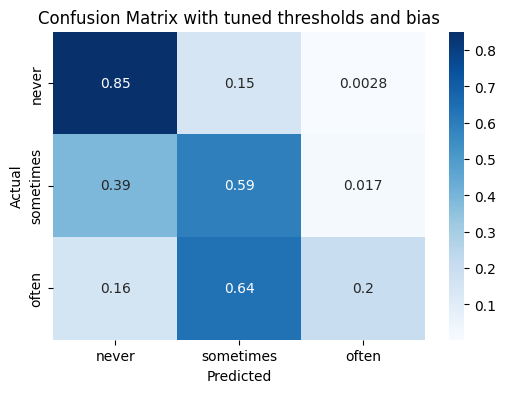

0.5395782051023802

that did not improve anything really

Let's see if oversampling the minority class within model will help.

In [ ]:
get_report(log_regressor_ovsamp, x_test, y_test)
# 5) Evaluate on your test set
probs_test = log_regressor_ovsamp.predict_proba(x_test)
y_pred_thr = predict_with_thresholds(probs_test, t_opt_o, t_opt_s)

print("Thresholded: ")
print(f1_score(y_test, y_pred_thr, average="weighted"))

unique_labels = y_test.value_counts().index.tolist()
print(
    classification_report(
        y_test,
        y_pred_thr,
        labels=unique_labels,
        target_names=["never", "sometimes", "often"],
        zero_division=0,  # avoid ‘undefined’ warnings if a class is missing
    )
)


cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds and oversampling')
plt.show()

In [94]:
from imblearn.over_sampling import SMOTENC

# Identify which feature indices are truly categorical/boolean
cat_idxs = [x_train.columns.get_loc(c) for c in x_train.columns if c not in num_cols]

smote_nc = SMOTENC(
    categorical_features=cat_idxs,
    random_state=42
)

x_res, y_res = smote_nc.fit_resample(x_train, y_train)
log_regressor_ovsamp = LogisticRegression(random_state=10, max_iter=1000)
log_regressor_ovsamp.fit(x_res, y_res)

LogisticRegression(max_iter=1000, random_state=10)

Best 'often' thresh: 0.3202013202673587 F1_often: 0.07390300230915894
Best 'sometimes' thresh: 0.44747177787426506 F1_sometimes: 0.4179023995681384


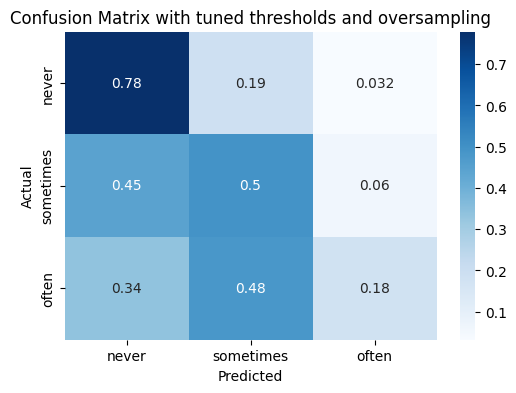

0.4358177077649427


In [98]:
# 5) Evaluate on your test set
probs = log_regressor_ovsamp.predict_proba(x_test)
t_opt_o, t_opt_s = get_best_thresholds(probs, y_test)
y_pred_thr = predict_with_thresholds(probs, t_opt_o, t_opt_s)

cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds and oversampling')
plt.show()
print(f1_score(y_test, y_pred_thr, average="macro"))

reduce features if that will have effect on log regressor model

In [14]:
from sklearn.feature_selection import RFE


rfe = RFE(
    estimator=log_regressor,
    n_features_to_select=45,
    step=5,           # remove 5 features per iteration
)

# 3) fit only on train
rfe.fit(x_train, y_train)

# 4) transform your sets
x_train_rfe = rfe.transform(x_train)
x_test_rfe  = rfe.transform(x_test)

print("Kept features:", x_train_rfe.shape[1])
kept_feature_names = [x_train.columns[i] for i, keep in enumerate(rfe.support_) if keep]
print("Kept feature names:", kept_feature_names)

grid.fit(x_train_rfe, y_train)

print("Best C:", grid.best_params_["C"])
print("CV Macro-F1:", grid.best_score_)

Kept features: 30
Kept feature names: ['age', 'smokes', 'body_type_jacked', 'body_type_overweight', 'body_type_rather not say', 'body_type_skinny', 'body_type_used up', 'drinks_desperately', 'drinks_often', 'drinks_rarely', 'drinks_socially', 'drinks_very often', 'job_artistic / musical / writer', 'job_military', 'job_rather not say', 'job_retired', 'job_unemployed', 'orientation_gay', 'orientation_straight', 'pets_dislikes dogs', 'pets_dislikes dogs and likes cats', 'pets_has cats', 'pets_likes cats', 'indian', 'education_bucket_lower', 'is_single', 'strict_diet', 'strict_religion', 'halal', 'kosher']
Best C: 10
CV Macro-F1: 0.8020393172915379
Best C: 10
CV Macro-F1: 0.8020393172915379


Best 'often' thresh: 0.06780274816280982 F1_often: 0.20083682008322867
Best 'sometimes' thresh: 0.2080329188806009 F1_sometimes: 0.4814910691167926


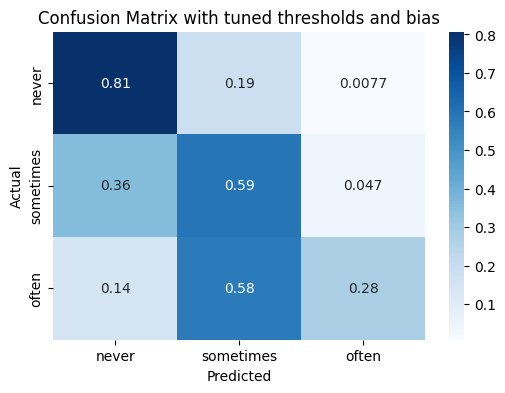

In [15]:
probs_test = grid.predict_proba(x_test_rfe)
t_opt_o, t_opt_s = get_best_thresholds(probs=probs_test, y_test=y_test)
y_pred_thr = predict_with_thresholds(probs_test, t_opt_o, t_opt_s)

cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds and bias')
plt.show()
f1_score(y_test, grid.predict(x_test_rfe), average="macro")

finally, let's try just binary classification - drugs or not - if we can get better

Best 'often' thresh: 0.08882607023418262 F1_often: 0.22009569377942548
Best 'sometimes' thresh: 0.2280948883807114 F1_sometimes: 0.5049833887038335


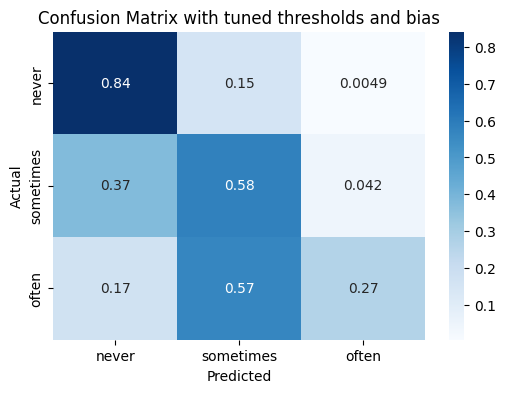

0.4317836103315778

In [107]:
labels_binary = (labels != 0)
x_train, x_test, y_train, y_test = train_test_split(features, labels_binary, test_size=.2, random_state=21)

it is evident that feature reduction did no help regarding performance

Dtree basic

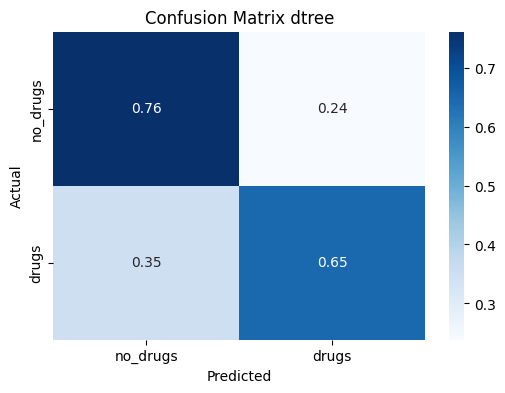

0.7412252016568563

In [108]:
dtree.fit(x_train, y_train)

cm = confusion_matrix(y_test, dtree.predict(x_test), normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=["no_drugs", "drugs"], yticklabels=["no_drugs", "drugs"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix dtree')
plt.show()
f1_score(y_test, dtree.predict(x_test), average="macro")

Dtree tuned

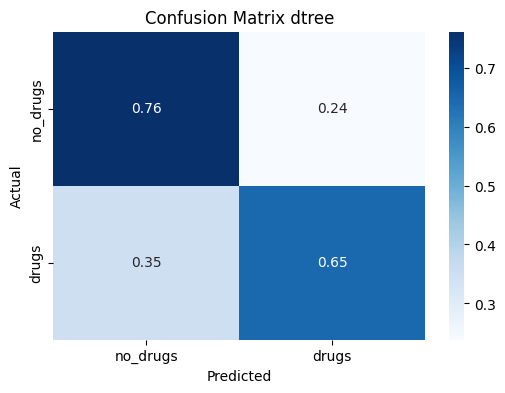

0.6509244323514779

In [119]:
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy']
}
grid_dtree = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    scoring="recall",
    cv=5,
)
grid_dtree.fit(x_train, y_train)

In [22]:
grid.fit(x_train, y_train)

Kept features: 30
Kept feature names: ['smokes', 'body_type_used up', 'drinks_desperately', 'drinks_often', 'drinks_rarely', 'drinks_socially', 'drinks_very often', 'job_artistic / musical / writer', 'job_banking / financial / real estate', 'job_executive / management', 'job_law / legal services', 'job_medicine / health', 'job_military', 'job_transportation', 'job_unemployed', 'orientation_gay', 'orientation_straight', 'pets_dislikes dogs and likes cats', 'pets_has cats', 'pets_has dogs and likes cats', 'pets_likes cats', 'pets_likes dogs and has cats', 'pets_likes dogs and likes cats', 'indian', 'education_bucket_lower', 'male', 'is_single', 'vegan', 'vegetarian', 'halal']


Kept features: 30
Kept feature names: ['smokes', 'body_type_used up', 'drinks_desperately', 'drinks_often', 'drinks_rarely', 'drinks_socially', 'drinks_very often', 'job_artistic / musical / writer', 'job_banking / financial / real estate', 'job_executive / management', 'job_law / legal services', 'job_medicine / health', 'job_military', 'job_transportation', 'job_unemployed', 'orientation_gay', 'orientation_straight', 'pets_dislikes dogs and likes cats', 'pets_has cats', 'pets_has dogs and likes cats', 'pets_likes cats', 'pets_likes dogs and has cats', 'pets_likes dogs and likes cats', 'indian', 'education_bucket_lower', 'male', 'is_single', 'vegan', 'vegetarian', 'halal']


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1, param_grid={'C': [1, 2, 5, 10, 15, 20, 50, 100]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted, zero_division=0))

In [120]:
from tools import get_best_thresh_binary
best_thr = get_best_thresh_binary(grid.predict_proba(x_test)[:, 1], y_test)
y_pred_thr = (grid.predict_proba(x_test)[:, 1] >= best_thr).astype(int)

cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=["no_drugs", "drugs"], yticklabels=["no_drugs", "drugs"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds and bias')
plt.show()
f1_score(y_test, grid.predict(x_test), average="macro")

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              max_depth=10, random_state=10),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall')

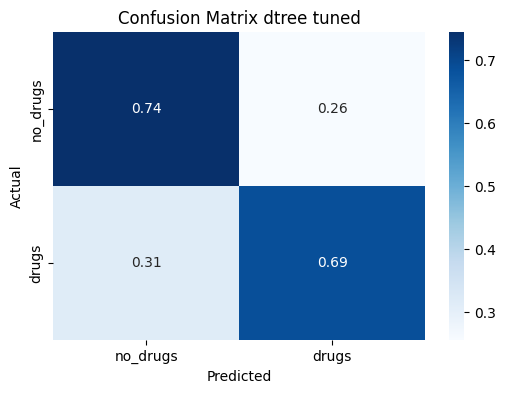

0.650843415569048

In [121]:
cm = confusion_matrix(y_test, grid_dtree.predict(x_test), normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=["no_drugs", "drugs"], yticklabels=["no_drugs", "drugs"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix dtree tuned')
plt.show()
f1_score(y_test, grid_dtree.predict(x_test), average="macro")

we get significantly better performance using binary labels, with dtree more accurate overall while regressor more restricted in misclassifying someone as drug user (if that would be our concern)

Last model to try - random forest classifier

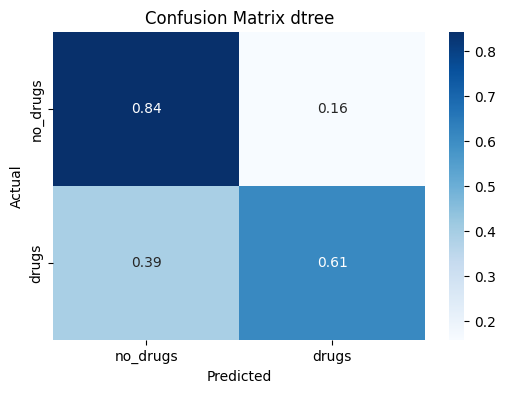

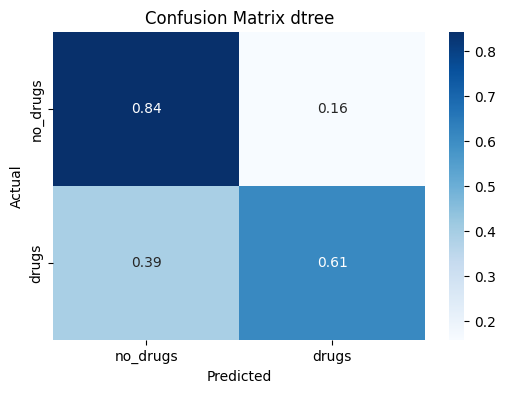

0.8003052103771529

In [38]:
from sklearn.ensemble   import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,          # number of trees
    max_depth=15,            # no limit on depth
    class_weight='balanced',   # up-weight minority class
    random_state=42,
)

# 2) Fit on your training set
rf.fit(x_train, y_train)

# 3) Predict on test set
y_pred = rf.predict(x_test)

cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=["no_drugs", "drugs"], yticklabels=["no_drugs", "drugs"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix dtree')
plt.show()
f1_score(y_test, rf.predict(x_test), average="macro")

In [128]:
# multiclass models
